# Capstone Project: find my next travel destination

In this Ipython notebook I will first aquire necessary data, explore the data, write functions to find similar cities based on the diversity of venues per city and demonstrate the how the functions work based on a few examples

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import plotly.express as px

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


## Step 1: Data aquisition
1.1 read and clean city/population data from UN  
1.2 get coordinates for all cities using `geopy.geocoder`  
1.3 bin population size  
1.4 for each city get all venues within 5km radius of city center using `foursquare` API

### 1.1 read and clean city/population data from UN

In [2]:
# possibly need to clean up the table a bit before. add countries to cities and remove footnotes

# read and format population table
population = pd.read_excel('table08_clean.xlsx')
population.head()

,City,Population Size,Country
0,Adrar,200834.0,Algeria
1,Ain Defla,450280.0,Algeria
2,Ain Temouchent,299341.0,Algeria
3,ALGIERS (EL DJAZAIR),2712944.0,Algeria
4,Annaba,442230.0,Algeria


### 1.2 get coordinates for all cities using `geopy.geocoder`

In [3]:
# add longitude and latitude to table
# initialize column, only necessary because it is using the column before it's first assignment
population['got_coordinates'] = ''

In [11]:
for i in population.index:
    city = population.at[i,'City']
    country = population.at[i,'Country']
    got_coordinates = population.at[i,'got_coordinates']
    if got_coordinates == '':
        print(city)
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode('%s, %s' %(city, country))
        if not location == None:
            # get longitude and latitude 
            latitude = location.latitude
            longitude = location.longitude
        else:
            latitude = np.nan
            longitude = np.nan
            country = np.nan
        population.at[i, 'got_coordinates'] = 'yes'            
        population.at[i, 'Latitude'] = latitude
        population.at[i, 'Longitude'] = longitude

print(population.shape)
population.head()

(2555, 6)


,City,Population Size,Country,got_coordinates,Latitude,Longitude
0,Adrar,200834.0,Algeria,yes,27.945887,-0.199294
1,Ain Defla,450280.0,Algeria,yes,36.158684,2.084282
2,Ain Temouchent,299341.0,Algeria,yes,35.266657,-1.149928
3,ALGIERS (EL DJAZAIR),2712944.0,Algeria,yes,36.775361,3.060188
4,Annaba,442230.0,Algeria,yes,36.898216,7.754927


In [12]:
population.drop('got_coordinates', axis = 1, inplace = True)
population.tail()

,City,Population Size,Country,Latitude,Longitude
2550,ADAMSTOWN,49.0,Pitcairn,-25.066667,-130.100205
2551,APIA,37391.0,Samoa,-13.834369,-171.769279
2552,HONIARA,64609.0,Solomon Islands,-9.431077,159.955255
2553,FUNAFUTI,6152.0,Tuvalu,-8.534995,179.118650
2554,PORT VILA,44039.0,Vanuatu,-17.741497,168.315016


### 1.3 bin population size  

In [13]:
# drop cities without location
population.dropna(inplace=True)
population.head()

def bin_pop_size(x):
    if x < 500000:
        bin_pop = 1
    elif x >= 500000 and x < 1000000:
        bin_pop = 2
    elif x >= 1000000 and x < 5000000:
        bin_pop = 3
    elif x >= 5000000 and x < 10000000:
        bin_pop = 4
    elif x >= 10000000 and x < 20000000:
        bin_pop = 5
    elif x >= 20000000:
        bin_pop = 6
    return bin_pop

# create a column indicating the bin based on population size
population['population_bin'] = population['Population Size'].apply(lambda x: bin_pop_size(x))

# safe table
population.to_excel('population_table.xlsx')

# look at table which we will use for the rest
print(population.shape)
population.head()


(2521, 6)


,City,Population Size,Country,Latitude,Longitude,population_bin
0,Adrar,200834.0,Algeria,27.945887,-0.199294,1
1,Ain Defla,450280.0,Algeria,36.158684,2.084282,1
2,Ain Temouchent,299341.0,Algeria,35.266657,-1.149928,1
3,ALGIERS (EL DJAZAIR),2712944.0,Algeria,36.775361,3.060188,3
4,Annaba,442230.0,Algeria,36.898216,7.754927,1


Okay, now that we have the cities location, their population size and their country  we can as foursquares to get all venues in a 5km radius around the city center

In [4]:
population = pd.read_excel('population_table.xlsx')
population.drop(['Unnamed: 0'], axis = 1, inplace = True)
population.head()

,City,Population Size,Country,Latitude,Longitude,population_bin
0,Adrar,200834.0,Algeria,27.945887,-0.199294,1
1,Ain Defla,450280.0,Algeria,36.158684,2.084282,1
2,Ain Temouchent,299341.0,Algeria,35.266657,-1.149928,1
3,ALGIERS (EL DJAZAIR),2712944.0,Algeria,36.775361,3.060188,3
4,Annaba,442230.0,Algeria,36.898216,7.754927,1


In [40]:
# setting up the credentials for Foursqaure

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 5000
radius = 5000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


### 1.4 for each city get all venues within 5km radius of city center using `foursquare` API

In [6]:
# function that extracts the category of the venue

def getNearbyVenues(names, latitudes, longitudes, radius=5000, LIMIT=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        
        if 'groups' in results['response'].keys() and len(results["response"]['groups'][0]['items']) > 0:
            results = results["response"]['groups'][0]['items']
            
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        
        
        else:
            # if there are no venues add nan for the city
            venues_list.append([(
                name, 
                lat, 
                lng, 
                np.nan, 
                np.nan, 
                np.nan,  
                np.nan)])
    
    # create a dataframe from results
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    # add column name
    nearby_venues.columns = ['City', 
                      'City Latitude', 
                      'City Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
    
    return(nearby_venues)

In [ ]:
# run the function
city_venues = getNearbyVenues(names=population['City'],
                                   latitudes=population['Latitude'],
                                   longitudes=population['Longitude']
                                  )

city_venues.head()


In [8]:
# safe table
# city_venues.to_excel('city_venues.xlsx')

# look at table which we will use for the rest
print(city_venues.shape)
city_venues.head()

(160973, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Ain Temouchent,35.266657,-1.149928,Fast food Le Loft,35.294999,-1.137600,Fast Food Restaurant
3,ALGIERS (EL DJAZAIR),36.775361,3.060188,Restaurant Le Thyrolien,36.775188,3.058731,BBQ Joint
4,ALGIERS (EL DJAZAIR),36.775361,3.060188,CARACOYA,36.766672,3.053610,French Restaurant
5,ALGIERS (EL DJAZAIR),36.775361,3.060188,"TNA ""Théâtre National d'Alger""",36.780978,3.060508,Theater
6,ALGIERS (EL DJAZAIR),36.775361,3.060188,Didouche Mourad,36.765570,3.051074,Plaza


In [9]:
# read in table
city_venues = pd.read_excel('city_venues.xlsx', index_col= 0)
city_venues.dropna(inplace = True)
city_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Ain Temouchent,35.266657,-1.149928,Fast food Le Loft,35.294999,-1.137600,Fast Food Restaurant
3,ALGIERS (EL DJAZAIR),36.775361,3.060188,Restaurant Le Thyrolien,36.775188,3.058731,BBQ Joint
4,ALGIERS (EL DJAZAIR),36.775361,3.060188,CARACOYA,36.766672,3.053610,French Restaurant
5,ALGIERS (EL DJAZAIR),36.775361,3.060188,"TNA ""Théâtre National d'Alger""",36.780978,3.060508,Theater
6,ALGIERS (EL DJAZAIR),36.775361,3.060188,Didouche Mourad,36.765570,3.051074,Plaza


In [10]:
population.head()

,City,Population Size,Country,Latitude,Longitude,population_bin
0,Adrar,200834.0,Algeria,27.945887,-0.199294,1
1,Ain Defla,450280.0,Algeria,36.158684,2.084282,1
2,Ain Temouchent,299341.0,Algeria,35.266657,-1.149928,1
3,ALGIERS (EL DJAZAIR),2712944.0,Algeria,36.775361,3.060188,3
4,Annaba,442230.0,Algeria,36.898216,7.754927,1


## Step 2: Data wrangeling
2.1 redefine groups  
2.2 get one-hot encoding for Venue Category and/or Grouped Venue Category  
2.3 summarize venues by city using sum  
2.4 merge with population data  

### 2.1 redefine groups (not doing that for now)

### 2.2 get one-hot encoding for Venue Category (and or Grouped Venue Category)

In [11]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

city_onehot.drop(['City'], axis = 1, inplace = True)

# add neighborhood column back to dataframe
city_onehot['City'] = city_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head()

,City,ATM,Acai House,Accessories Store,Acehnese Restaurant,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Agriturismo,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apple Wine Pub,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Ash and Haleem Place,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baiano Restaurant,Bakery,Balinese Restaurant,Ballroom,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Batik Shop,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belarusian Restaurant,Belgian Restaurant,Betawinese Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Bulgarian Restaurant,Bunsik Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Central Brazilian Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Cigkofte Place,Circus,Circus School,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Football Field,College Gym,College Hockey Rink,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Country Dance Club,Coworking Space,Credit Union,Creperie,Cretan Restaurant,Cricket Ground,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Currywurst Joint,Cycle Studio,Czech Restaurant,Dairy Store,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Dive Spot,Dizi Place,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Dosa Place,Drive-in Theater,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Emilia Restaurant,Empada House,Empanada Restaurant,English Restaurant,Entertainment Service,Estaminet,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,Franconian Res

### 2.3 summarize venues by city using sum 


In [12]:
city_grouped = city_onehot.groupby('City').sum().reset_index()
city_grouped.head()

,City,ATM,Acai House,Accessories Store,Acehnese Restaurant,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Agriturismo,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apple Wine Pub,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Ash and Haleem Place,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baiano Restaurant,Bakery,Balinese Restaurant,Ballroom,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Batik Shop,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belarusian Restaurant,Belgian Restaurant,Betawinese Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Bulgarian Restaurant,Bunsik Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Central Brazilian Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Cigkofte Place,Circus,Circus School,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Football Field,College Gym,College Hockey Rink,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Country Dance Club,Coworking Space,Credit Union,Creperie,Cretan Restaurant,Cricket Ground,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Currywurst Joint,Cycle Studio,Czech Restaurant,Dairy Store,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Dive Spot,Dizi Place,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Dosa Place,Drive-in Theater,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Emilia Restaurant,Empada House,Empanada Restaurant,English Restaurant,Entertainment Service,Estaminet,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,Franconian Res

### 2.4 merge with population data  

In [13]:
# add population and location data to data, and save table
population_venue_data = population.merge(city_grouped, on = 'City')
population_venue_data.to_excel('population_venue_data.xlsx')
population_venue_data.head()

,City,Population Size,Country,Latitude,Longitude,population_bin,ATM,Acai House,Accessories Store,Acehnese Restaurant,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Agriturismo,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apple Wine Pub,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Ash and Haleem Place,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baiano Restaurant,Bakery,Balinese Restaurant,Ballroom,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Batik Shop,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belarusian Restaurant,Belgian Restaurant,Betawinese Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Bulgarian Restaurant,Bunsik Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Central Brazilian Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Cigkofte Place,Circus,Circus School,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Football Field,College Gym,College Hockey Rink,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Country Dance Club,Coworking Space,Credit Union,Creperie,Cretan Restaurant,Cricket Ground,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Currywurst Joint,Cycle Studio,Czech Restaurant,Dairy Store,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Dive Spot,Dizi Place,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Dosa Place,Drive-in Theater,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Emilia Restaurant,Empada House,Empanada Restaurant,English Restaurant,Entertainment Service,Estaminet,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,F

## Step 3: Visualize data
3.1 PCA  
3.2 TSNE  
3.3 barplot or boxplot for group Venues  
3.4 plot number of venues vs. number of categories (showing diversity)  

In [14]:
population_venue_data = pd.read_excel('population_venue_data.xlsx')
population_venue_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
population_venue_data.head()

,City,Population Size,Country,Latitude,Longitude,population_bin,ATM,Acai House,Accessories Store,Acehnese Restaurant,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Agriturismo,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apple Wine Pub,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Ash and Haleem Place,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baiano Restaurant,Bakery,Balinese Restaurant,Ballroom,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Batik Shop,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belarusian Restaurant,Belgian Restaurant,Betawinese Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Bulgarian Restaurant,Bunsik Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Central Brazilian Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Cigkofte Place,Circus,Circus School,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Football Field,College Gym,College Hockey Rink,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Country Dance Club,Coworking Space,Credit Union,Creperie,Cretan Restaurant,Cricket Ground,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Currywurst Joint,Cycle Studio,Czech Restaurant,Dairy Store,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Dive Spot,Dizi Place,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Dosa Place,Drive-in Theater,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Emilia Restaurant,Empada House,Empanada Restaurant,English Restaurant,Entertainment Service,Estaminet,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,F

### 3.1 PCA

(2343, 756)
Explained variation per principal component: [0.01730232 0.01266837]


<Figure size 432x288 with 0 Axes>

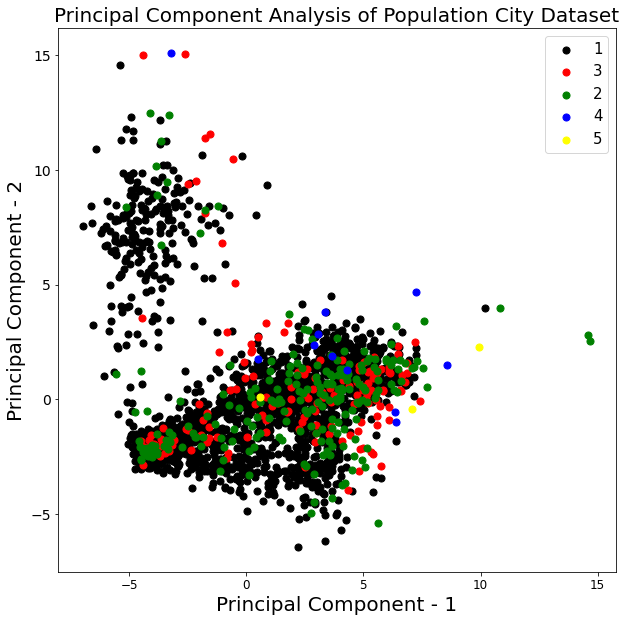

In [15]:
# look at data with PCA and TSNE

# remove city and country for the PCA
X = population_venue_data.drop(population_venue_data.iloc[:, [0,2]], inplace=False, axis=1)
print(X.shape)

x_pca = StandardScaler().fit_transform(X) # normalizing the features
pca_cities = PCA(n_components=2)
principalComponents_cities = pca_cities.fit_transform(x_pca)
PC_cities_Df = pd.DataFrame(data = principalComponents_cities
             , columns = ['principal component 1', 'principal component 2'])
print('Explained variation per principal component: {}'.format(pca_cities.explained_variance_ratio_))

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Population City Dataset",fontsize=20)
targets = population_venue_data['population_bin'].unique()
colors = ['black','red', 'green', 'blue', 'yellow']
for target, color in zip(targets,colors):
    indicesToKeep = population_venue_data['population_bin'] == target
    plt.scatter(PC_cities_Df.loc[indicesToKeep, 'principal component 1']
               , PC_cities_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

# save plot
plt.savefig('figures/pca.png', format = 'png')
plt.savefig('figures/pca.pdf', format = 'pdf')


### 3.2 TSNE

<Figure size 432x288 with 0 Axes>

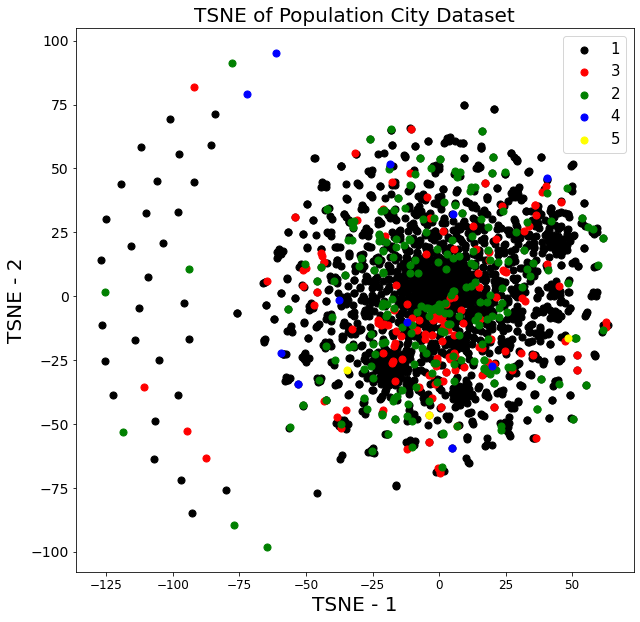

In [16]:
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

X = population_venue_data.drop(population_venue_data.iloc[:, 0:3], inplace=False, axis=1)

tsne = TSNE(perplexity = 20)
X_embedded = tsne.fit_transform(StandardScaler().fit_transform(X))

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('TSNE - 1',fontsize=20)
plt.ylabel('TSNE - 2',fontsize=20)
plt.title("TSNE of Population City Dataset",fontsize=20)

targets = population_venue_data['population_bin'].unique()
colors = ['black','red', 'green', 'blue', 'yellow']

for target, color in zip(targets,colors):
    indicesToKeep = population_venue_data['population_bin'] == target
    plt.scatter(X_embedded[indicesToKeep,0]
               , X_embedded[indicesToKeep,1], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.savefig('figures/tsne.png', format = 'png')
plt.savefig('figures/tsne.pdf', format = 'pdf')


### 3.3.1 histogram of how often a venue is present

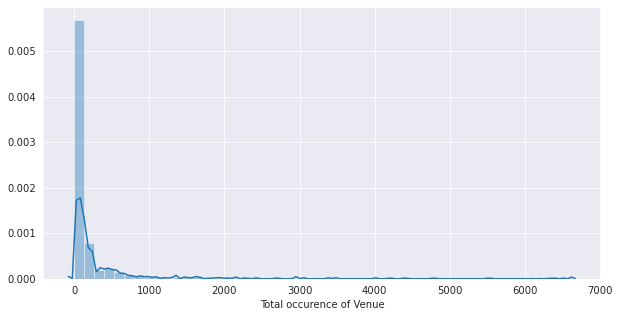

In [17]:
occurence_of_venues = population_venue_data.drop(population_venue_data.iloc[:, 0:6], inplace=False, axis=1).sum(axis =0)
occurence_of_venues

plt.figure(figsize=(10,5))

sns.set_style('darkgrid')
sns.distplot(occurence_of_venues)
plt.xlabel("Total occurence of Venue")


plt.savefig('figures/occurrence_per_venue.png', format = 'png')
plt.savefig('figures/occurrence_per_venue.pdf', format = 'pdf')


### 3.3.1 histogram of how many venues each city has

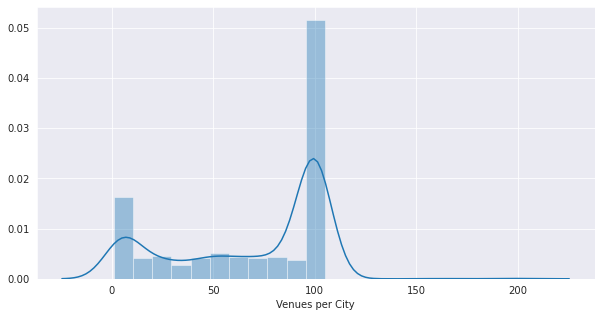

In [18]:
venues_per_city = population_venue_data.drop(population_venue_data.iloc[:, 0:6], inplace=False, axis=1).sum(axis = 1)
venues_per_city

plt.figure(figsize=(10,5))

sns.set_style('darkgrid')
sns.distplot(venues_per_city)
plt.xlabel("Venues per City")

plt.savefig('figures/venues_per_city.png', format = 'png')
plt.savefig('figures/venues_per_city.pdf', format = 'pdf')


### 3.4 plot number of venues vs. number of categories (showing diversity)  

In [19]:
# venues_per_city from previous cell
# calculate category per city

tmp = population_venue_data.drop(population_venue_data.iloc[:, 0:6], inplace=False, axis=1)
category_per_city = tmp.mask(tmp > 0, 1).sum(axis = 1)
category_per_city.head()

0     1
1    34
2    11
3     5
4     2
dtype: int64

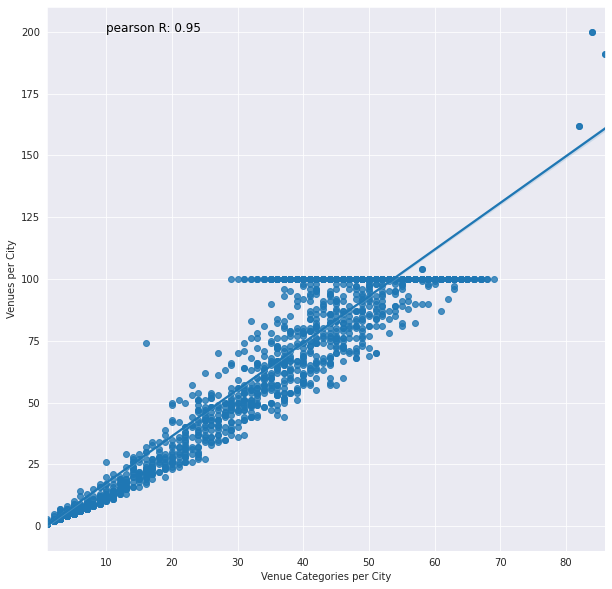

In [20]:
from scipy import stats 
plt.figure(figsize=(10,10))

sns.set_style('darkgrid')
ax = sns.regplot(x=category_per_city, y=venues_per_city)
plt.xlabel("Venue Categories per City")
plt.ylabel("Venues per City")
pearsonR = stats.pearsonr(category_per_city, venues_per_city)
ax.text(10, 200, 'pearson R: %s' %(np.round(pearsonR[0], 2)), horizontalalignment='left', size='larger', color='black')


plt.savefig('figures/venues_per_city_vs_categories.png', format = 'png')
plt.savefig('figures/venues_per_city_vs_categories.pdf', format = 'pdf')


In [21]:
np.round(pearsonR[0], 2)

0.95

The figure shows a clear indication that most cities are balanced in their repertoire of different venues the more venues they have

## Step 4: Write function to find similar city
4.1 input: population/venue data, favorite city, number of similar cities, choice of algorithm, select or deselect categories  
4.2 remove or select specified categories  
4.3 use hierachical clustering to find x similar cities  
4.4 return similar cities  
4.5 make a heatmap showing similar cities and features (!=0)  

### Function find_next_vacation()

In [22]:
def find_next_vacation(input_city, population_venue_data, k, distance_method): #, select, selected_features, distance_score):

    # include the selected features
    
    # only work on venue data
    tmp = population_venue_data.drop(population_venue_data.iloc[:, 0:6], inplace=False, axis=1)
    # remove or select given features
    print("selected features") 
    
    # calculate similarity to input_city
    distance_matrix = pd.DataFrame(squareform(pdist(tmp, distance_method)))
    distance_matrix.columns = population_venue_data['City']
    distance_matrix.index = population_venue_data['City']
    print("calculated distance matrix") 
    
    if not input_city in population_venue_data['City'].tolist():
        print("ERROR, we could not find your city")
        return
    else:
        # subset to k most similar cities
        next_vacations_cities = distance_matrix.sort_values(by = input_city)[input_city].head(n = k + 1).index.tolist()
        distance_to_input_city = distance_matrix.sort_values(by = input_city)[input_city].head(n = k + 1)
        next_vacations = population_venue_data[population_venue_data['City'].isin(next_vacations_cities)]
        print("found possible vacation destinations")
        
        # clean df (i.e. remove 0 features)
        next_vacations = next_vacations.loc[:, (next_vacations.loc[next_vacations['City'] == input_city,:] != 0).any(axis=0)]
        # sort by city
        next_vacations = next_vacations.merge(distance_to_input_city, on = 'City')
        next_vacations = next_vacations.sort_values(by = input_city)
        
        
        ###################################
        # create heatmap with clustering  #
        ###################################
        print("plotting heatmap")
        plt.figure()
        # plot heatmap of data
        heatmap_data = next_vacations.drop(next_vacations.iloc[:, 0:5], inplace=False, axis=1)
        heatmap_data.drop([input_city], axis = 1, inplace = True)
        heatmap_data.index = next_vacations['City']
        
        heatmap_data.sort_values(by = input_city, axis=1, ascending=False, inplace=True, kind='quicksort', na_position='last')
        ax = sns.clustermap(heatmap_data, method = 'ward', metric = distance_method, col_cluster = False, figsize = (25,10))
        # show, save heatmap and start new plot
        
        plt.savefig('figures/heatmap_%s.png' %(input_city.replace(' ', '.')), format = 'png')
        plt.savefig('figures/heatmap_%s.pdf' %(input_city.replace(' ', '.')), format = 'pdf')

        ###################################
        # plot dots hue is distance score #
        ###################################
        
        print("plotting world map")
        plt.figure()
        plot_data = next_vacations.iloc[:, 0:6]
        plot_data = plot_data.merge(distance_to_input_city, on = 'City')
        
        plot_data['log10(Population Size)'] = np.log10(plot_data['Population Size'])
        input_city_data = plot_data[plot_data['City'] == input_city]
        plot_data = plot_data[plot_data['City'] != input_city]
        
        sns.set(rc={'figure.figsize':(15,10)})
        ax = sns.scatterplot(x='Longitude', y='Latitude', hue = input_city, size = 'log10(Population Size)', data = plot_data)
        
        # long and lat max
        plt.xlim(population_venue_data['Longitude'].min(), population_venue_data['Longitude'].max())
        plt.ylim(population_venue_data['Latitude'].min(), population_venue_data['Latitude'].max())
        
        # city label names
        for i in range(0, plot_data.shape[0]):
            ax.text(plot_data.iloc[i, :]['Longitude'], plot_data.iloc[i, :]['Latitude'], plot_data.iloc[i, :]['City'], horizontalalignment='left', size='medium', color='black', weight='light', verticalalignment='bottom')
        
        # add input city to plot
        ax = sns.scatterplot(x='Longitude', y='Latitude', color = 'red', data = input_city_data )
        for i in range(0, input_city_data.shape[0]):
            ax.text(input_city_data.iloc[i, :]['Longitude'], input_city_data.iloc[i, :]['Latitude'], input_city_data.iloc[i, :]['City'], horizontalalignment='left', size='medium', color='red', weight='light', verticalalignment='bottom')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        
        plt.savefig('figures/worldmap_%s.png' %(input_city.replace(' ', '.')), format = 'png')
        plt.savefig('figures/worldmap_%s.pdf' %(input_city.replace(' ', '.')), format = 'pdf')

    
    # plot cities by their location, color with similarity score
    return next_vacations

In [23]:
def get_information_on_next_vacation(input_city, population_venue_data, LIMIT = 20):
    # use foursquares to get dataframe of venues for next city vacations
    
    latitudes = population_venue_data[population_venue_data['City'] == input_city]['Latitude']
    longitudes = population_venue_data[population_venue_data['City'] == input_city]['Longitude']
    
    venues_list=[]
    for name, lat, lng in zip(input_city, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        
        if 'groups' in results['response'].keys() and len(results["response"]['groups'][0]['items']) > 0:
            results = results["response"]['groups'][0]['items']
            
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                input_city, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        
        
        else:   
            venues_list.append([(
                name, 
                lat, 
                lng, 
                np.nan, 
                np.nan, 
                np.nan,  
                np.nan)])
    
    city_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    city_venues.columns = ['City', 
                      'City Latitude', 
                      'City Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
    
    return(city_venues)

## Step 5: Apply functions
5.1 show the result for 5 examples  
5.2 pretend to select a city  
5.3 use `foursquare` to get more information on an example city  

### 5.1 show the result for 5 examples

### 5.1.1 BERLIN, Germany

selected features
calculated distance matrix
found possible vacation destinations
plotting heatmap
plotting world map


,City,Population Size,Country,Latitude,Longitude,population_bin,Art Gallery,Art Museum,Arts & Crafts Store,Bakery,Bar,Beer Bar,Bike Rental / Bike Share,Bistro,Bookstore,Breakfast Spot,Brewery,Café,Canal,Capitol Building,Caucasian Restaurant,Church,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Cycle Studio,Deli / Bodega,Drugstore,Event Space,Falafel Restaurant,Farmers Market,Fountain,Garden,Gourmet Shop,Historic Site,Hotel,Ice Cream Shop,Indie Theater,Italian Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Mediterranean Restaurant,Monument / Landmark,Nail Salon,Noodle House,Park,Pastry Shop,Plaza,Roof Deck,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Spa,Spanish Restaurant,Theater,Vacation Rental,Vegetarian / Vegan Restaurant,Volleyball Court,Waterfront,Wine Bar,BERLIN
6,BERLIN,3613495.0,Germany,52.517037,13.388860,3,2,1,1,3,1,1,1,2,5,1,1,2,1,1,1,1,1,10,4,1,1,1,1,1,1,1,1,2,2,1,3,5,1,1,1,1,1,1,1,3,1,1,5,2,1,1,1,3,1,1,1,1,1,1,2,1,2,3,0.000000
1,Toronto,2956024.0,Canada,43.653482,-79.383935,3,1,0,1,5,0,1,0,0,0,0,1,2,0,0,0,0,1,11,1,1,0,0,0,1,0,2,0,2,1,2,1,1,0,0,0,0,0,0,1,1,0,0,7,0,2,0,0,3,0,0,1,0,1,0,2,0,0,0,14.071247
3,Portland (OR),639863.0,United States of America,45.520247,-122.674195,2,0,1,0,3,2,1,0,0,4,1,5,0,0,0,0,0,2,13,2,0,0,1,0,0,0,1,0,0,0,0,6,1,0,2,0,0,0,0,1,0,0,0,4,0,0,0,0,2,0,0,0,1,0,0,1,0,0,0,14.560220
9,s-Gravenhage,514861.0,The Netherlands,52.074946,4.269680,2,0,3,0,3,4,1,0,1,3,2,2,5,0,0,0,0,0,6,2,0,0,2,0,1,0,0,0,1,0,0,2,2,0,2,0,0,0,0,1,0,0,0,5,0,2,0,0,2,3,1,0,0,2,0,0,0,0,0,14.696938
4,Pare Pare,142391.0,Indonesia,-4.005706,119.623610,1,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,0,0,0,2,0,0,0,0,2,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,14.730920


<Figure size 432x288 with 0 Axes>

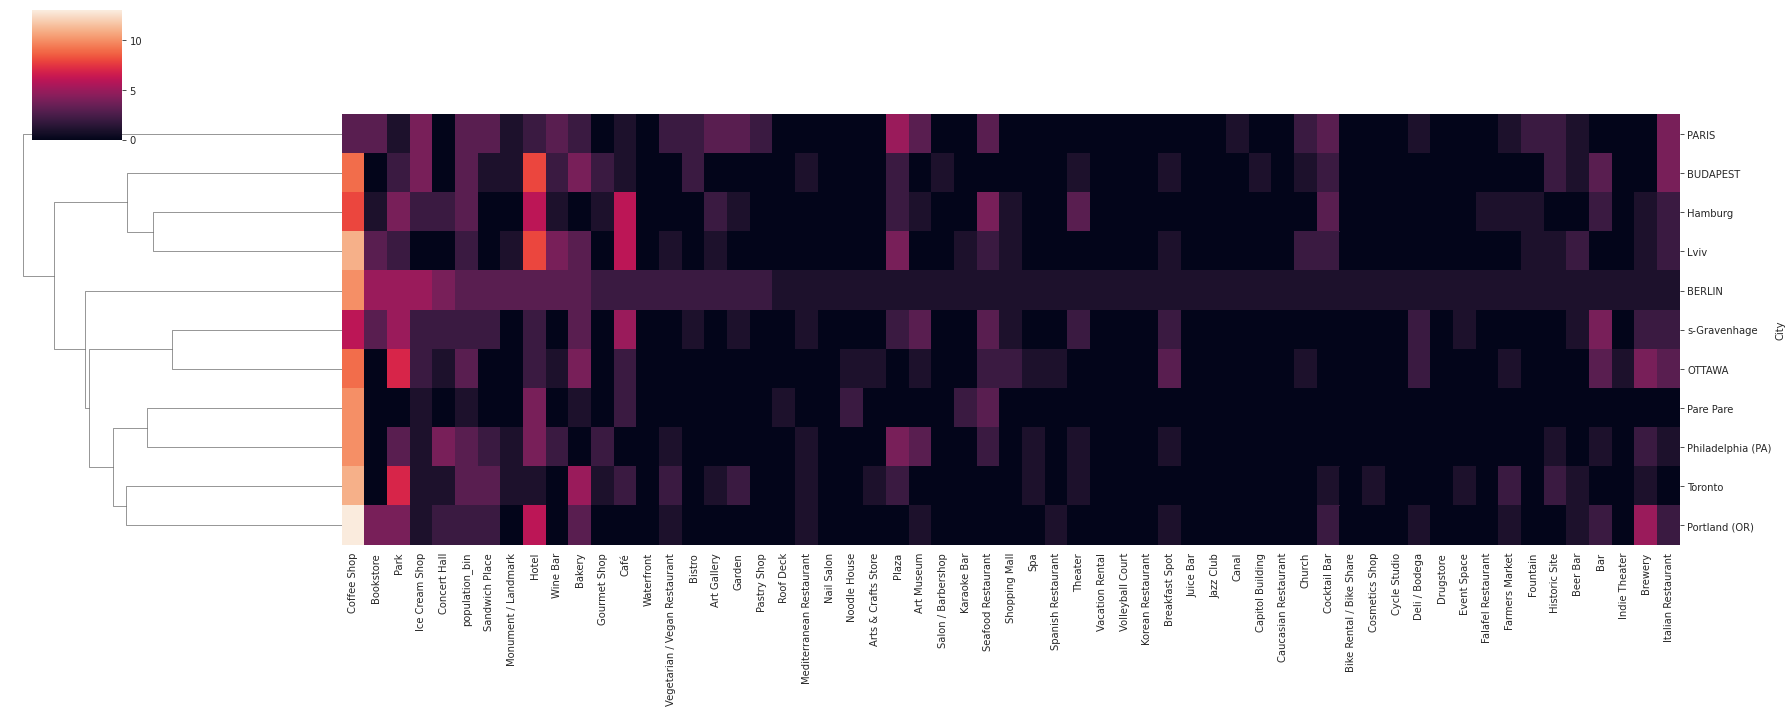

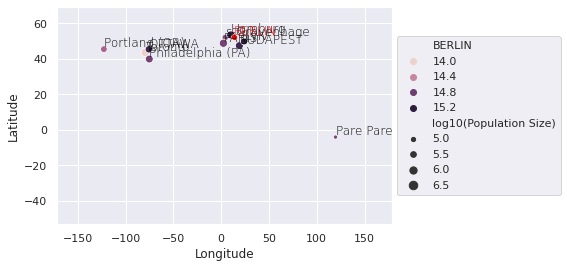

In [24]:
future_vacation_destination_Berlin = find_next_vacation('BERLIN', population_venue_data, 10, 'euclidean')
future_vacation_destination_Berlin.head()

### 5.1.2 Chicago (IL), USA

selected features
calculated distance matrix
found possible vacation destinations
plotting heatmap
plotting world map


,City,Population Size,Country,Latitude,Longitude,population_bin,Amphitheater,Aquarium,Art Museum,Arts & Crafts Store,Bar,Boat or Ferry,Breakfast Spot,Café,Chocolate Shop,Cocktail Bar,Coffee Shop,Concert Hall,Cuban Restaurant,Cupcake Shop,Diner,Donut Shop,Event Service,Football Stadium,Fountain,Garden,Gastropub,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,History Museum,Hot Dog Joint,Hotel,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Liquor Store,Market,Mediterranean Restaurant,Museum,Music Venue,New American Restaurant,Opera House,Other Great Outdoors,Outdoor Sculpture,Park,Salad Place,Sandwich Place,Seafood Restaurant,Skating Rink,Steakhouse,Sushi Restaurant,Theater,Tour Provider,Trail,Waterfront,Women's Store,Yoga Studio,Chicago (IL)
3,Chicago (IL),2704958.0,United States of America,41.875562,-87.624421,3,1,1,1,1,1,2,2,2,1,1,3,1,1,1,1,3,1,1,2,1,1,1,7,3,1,1,2,2,10,1,3,1,1,2,1,1,1,2,3,1,1,1,6,1,3,2,1,1,1,3,2,1,2,1,1,0.000000
1,Saguenay,146436.0,Canada,48.405959,-71.069183,1,0,0,0,0,0,0,1,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,7,0,1,0,1,0,5,0,2,0,0,2,0,0,0,0,0,0,0,0,1,0,3,0,0,1,1,1,0,0,0,0,0,14.142136
2,PORT-AU-PRINCE,990558.0,Haiti,18.547327,-72.339593,2,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,2,0,5,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,14.764823
4,Puerto Montt,213119.0,Chile,-41.471812,-72.939621,1,0,0,0,0,1,0,1,2,0,0,2,0,0,0,2,0,0,0,0,0,1,0,1,1,1,0,0,0,5,0,2,1,0,0,0,0,0,0,0,0,1,0,0,0,3,6,0,1,0,1,0,0,0,0,1,15.000000
9,Yaroslavl,597161.0,Russia,57.649553,39.874858,2,0,0,1,0,2,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,1,0,4,5,1,0,3,0,12,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,1,0,0,2,0,1,1,1,0,15.000000


<Figure size 1080x720 with 0 Axes>

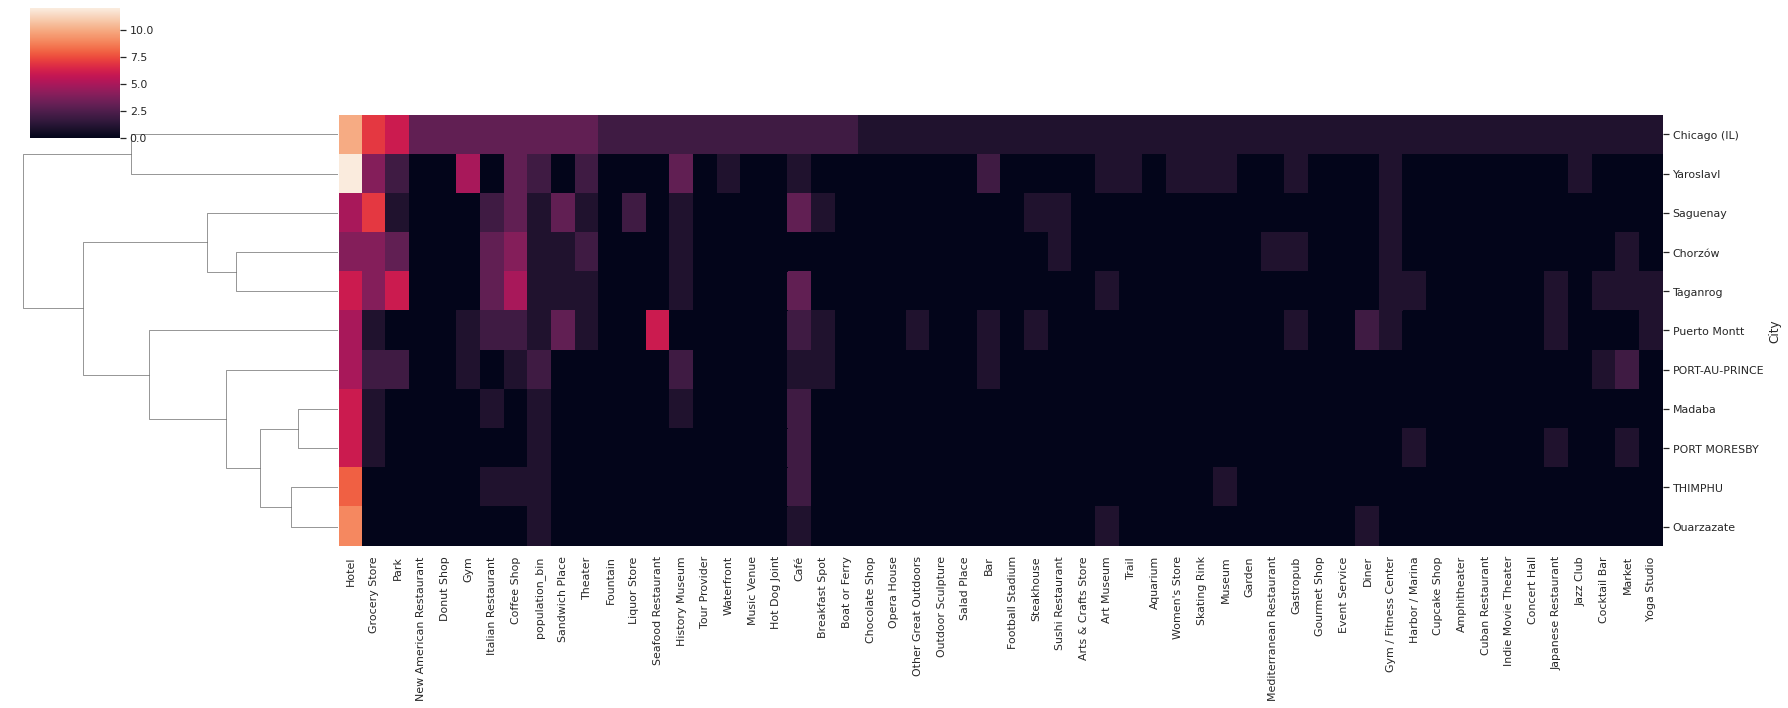

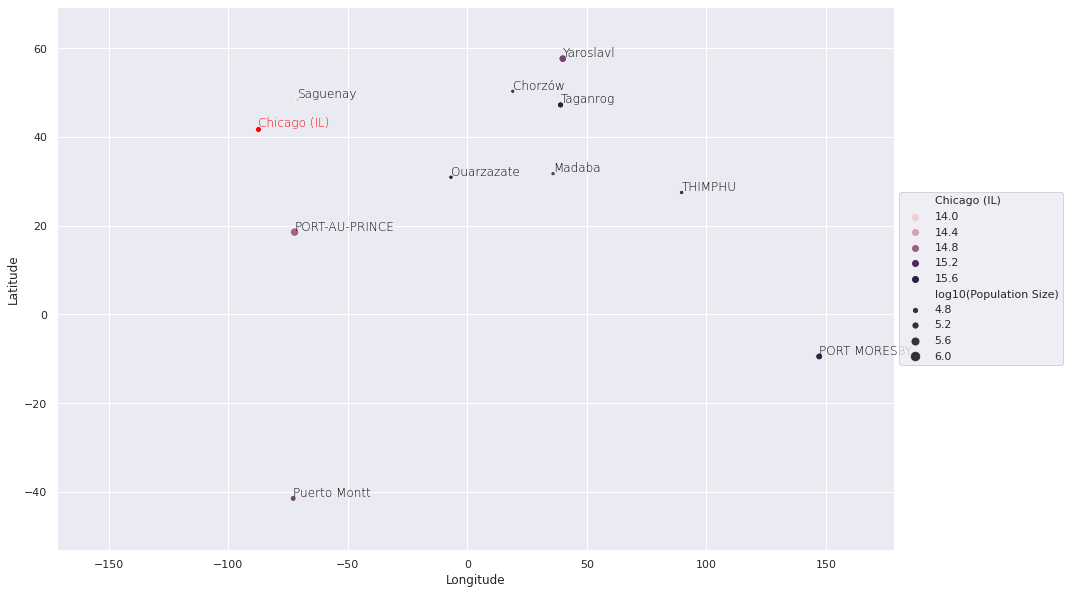

In [25]:
future_vacation_destination = find_next_vacation('Chicago (IL)', population_venue_data, 10, 'euclidean')
future_vacation_destination.head()

### 5.1.3 Leiden, Netherlands

selected features
calculated distance matrix
found possible vacation destinations
plotting heatmap
plotting world map


,City,Population Size,Country,Latitude,Longitude,population_bin,Bagel Shop,Bakery,Bar,Bistro,Bowling Alley,Breakfast Spot,Brewery,Café,Chinese Restaurant,Climbing Gym,Coffee Shop,Convenience Store,Convention Center,Creperie,Dance Studio,Diner,Drugstore,Field,Flower Shop,French Restaurant,Garden Center,Gastropub,Grocery Store,Gym,Hardware Store,Historic Site,Hockey Field,Hotel,Ice Cream Shop,Italian Restaurant,Lake,Market,Movie Theater,Museum,Noodle House,Park,Playground,Pool,Pub,Record Shop,Restaurant,Sandwich Place,Science Museum,Seafood Restaurant,Shopping Mall,Soccer Field,Stadium,Supermarket,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tunnel,Leiden
7,Leiden,121562.0,The Netherlands,52.151816,4.481109,1,1,3,5,2,1,1,1,6,2,1,2,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1,1,1,3,1,1,1,4,1,3,1,1,3,2,8,3,2,1,1,1,1,9,1,2,2,1,1,1,0.000000
3,Delft,101030.0,The Netherlands,52.011402,4.358390,1,0,2,3,0,0,1,1,6,1,0,3,0,0,0,0,0,0,0,1,4,1,2,0,2,0,1,1,2,2,3,0,1,0,0,0,4,1,2,3,1,5,2,0,1,0,0,0,7,0,1,1,1,0,0,11.135529
1,Alkmaar,107106.0,The Netherlands,52.631259,4.750380,1,1,1,1,2,0,0,0,4,0,0,4,0,0,0,0,0,1,0,0,2,2,1,1,1,0,0,0,1,3,1,0,0,1,1,0,2,0,1,1,0,5,0,0,0,1,1,0,4,1,0,0,1,0,0,12.727922
4,Dordrecht,118899.0,The Netherlands,51.795881,4.677935,1,0,2,4,0,0,1,0,6,1,0,1,0,0,1,0,2,1,0,0,3,2,1,0,3,0,0,0,2,5,3,0,0,1,1,0,4,0,0,0,1,13,2,0,1,1,0,0,6,1,0,0,1,0,0,12.727922
2,Apeldoorn,158099.0,The Netherlands,52.215646,5.963948,1,0,0,2,0,0,0,1,5,1,0,3,0,0,0,0,3,0,0,0,2,1,0,3,0,0,0,1,1,4,4,0,1,1,1,0,3,1,2,2,0,6,2,0,0,1,1,1,5,1,1,0,2,0,0,13.038405


<Figure size 1080x720 with 0 Axes>

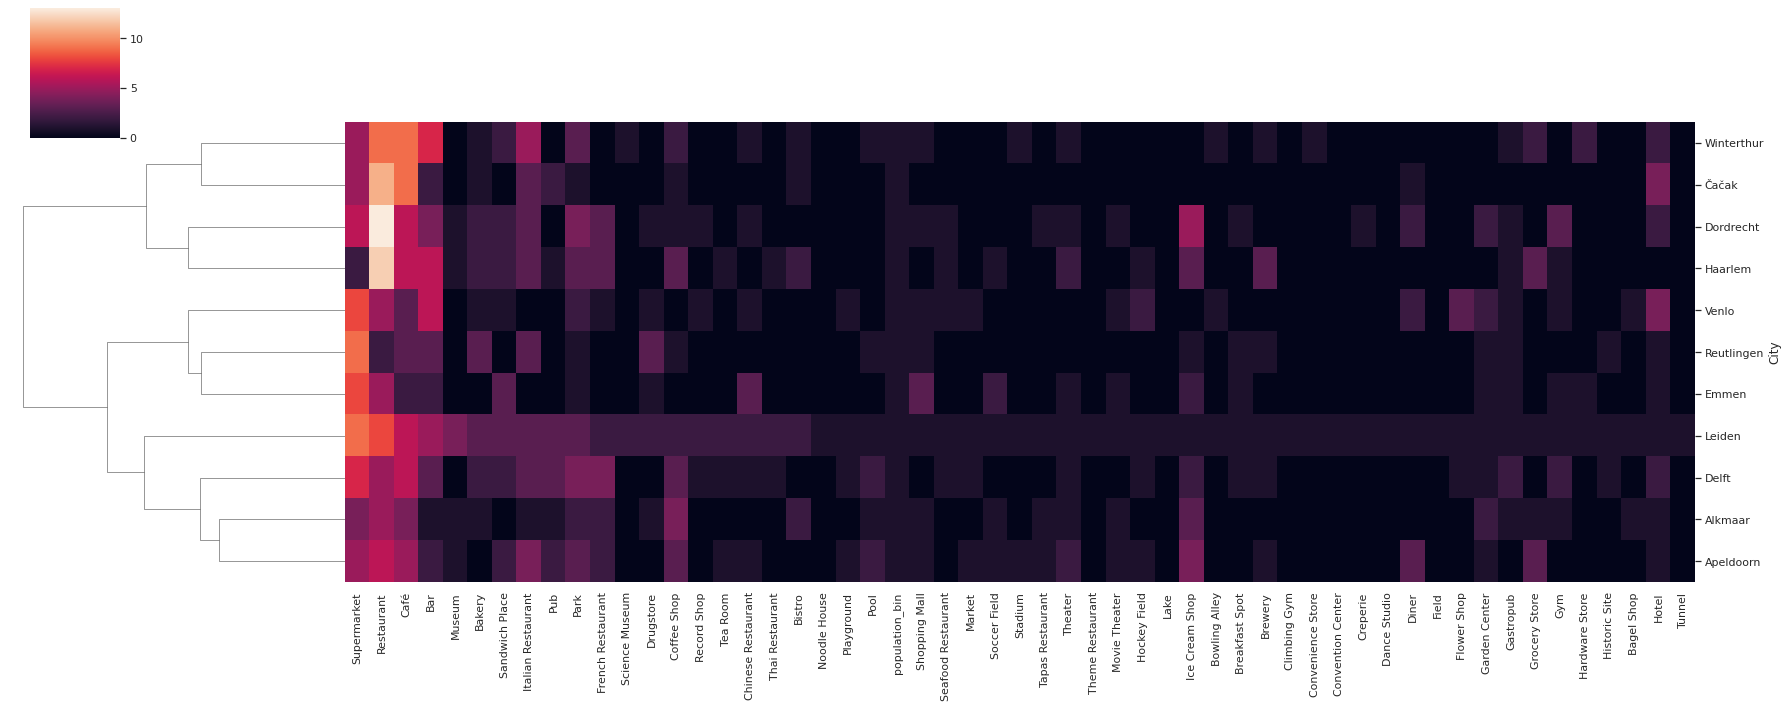

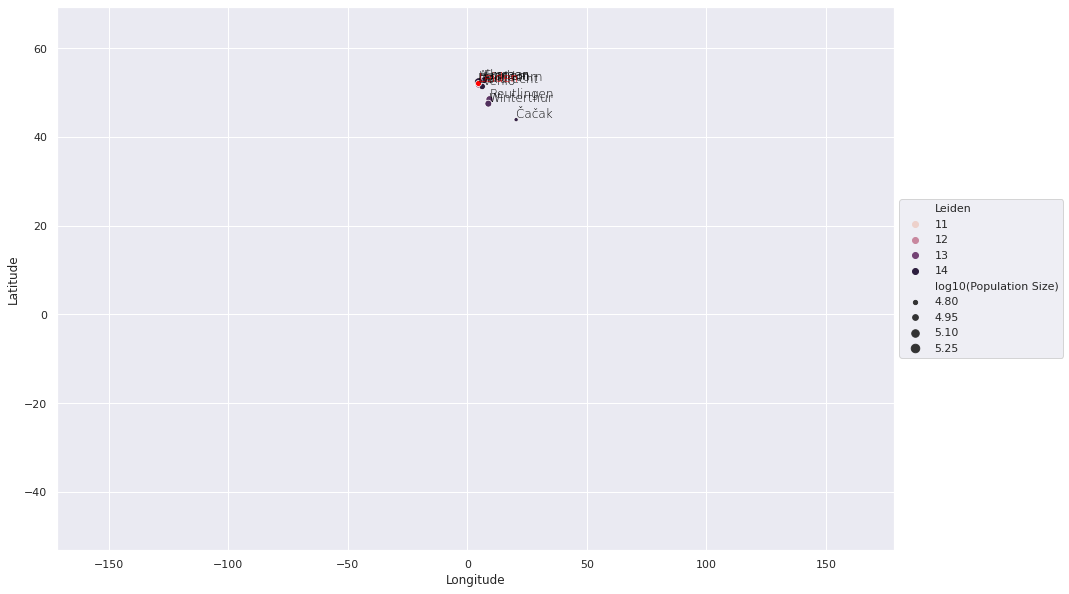

In [26]:
future_vacation_destination = find_next_vacation('Leiden', population_venue_data, 10, 'euclidean')
future_vacation_destination.head()

### 5.1.4 TOKYO, Japan

selected features
calculated distance matrix
found possible vacation destinations
plotting heatmap
plotting world map


,City,Population Size,Country,Latitude,Longitude,population_bin,Art Museum,BBQ Joint,Bed & Breakfast,Bookstore,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Dessert Shop,Donburi Restaurant,Electronics Store,French Restaurant,Garden,Historic Site,Hobby Shop,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kaiseki Restaurant,Kebab Restaurant,Lounge,Market,Multiplex,Nightclub,Noodle House,Okonomiyaki Restaurant,Park,Pastry Shop,Pet Café,Pet Store,Pub,Ramen Restaurant,Resort,Roof Deck,Sake Bar,Sandwich Place,Seafood Restaurant,Shrine,Soba Restaurant,South Indian Restaurant,Steakhouse,Sukiyaki Restaurant,Sushi Restaurant,Tempura Restaurant,Thai Restaurant,Tonkatsu Restaurant,Trail,Train Station,Udon Restaurant,Unagi Restaurant,Wagashi Place,Yakitori Restaurant,Yoshoku Restaurant,TOKYO
5,TOKYO,9272740.0,Japan,35.682839,139.759455,4,1,4,1,1,2,3,1,5,2,2,1,1,1,2,1,2,9,1,1,1,2,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,1,1,2,1,1,1,2,2,2,1,3,1,1,1,1,1,2,1,3,1,2,0.000000
4,Sapporo,1952356.0,Japan,43.061936,141.354292,3,0,2,1,3,5,4,0,4,0,2,0,1,0,0,1,1,10,0,0,0,4,3,0,1,0,0,0,0,2,0,3,0,2,1,0,0,0,2,0,0,7,1,1,0,2,0,0,0,5,0,0,0,0,1,1,0,0,1,0,14.000000
10,PORT MORESBY,364125.0,Papua New Guinea,-9.474330,147.159950,1,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.212670
3,Hikone,113679.0,Japan,35.254276,136.215376,1,0,0,0,1,2,0,1,3,0,0,0,0,0,1,2,0,2,0,1,2,0,3,0,0,1,0,0,0,0,0,1,1,2,1,0,0,0,4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,2,0,0,0,0,0,14.317821
2,THIMPHU,114551.0,Bhutan,27.472762,89.629548,1,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.352700


<Figure size 1080x720 with 0 Axes>

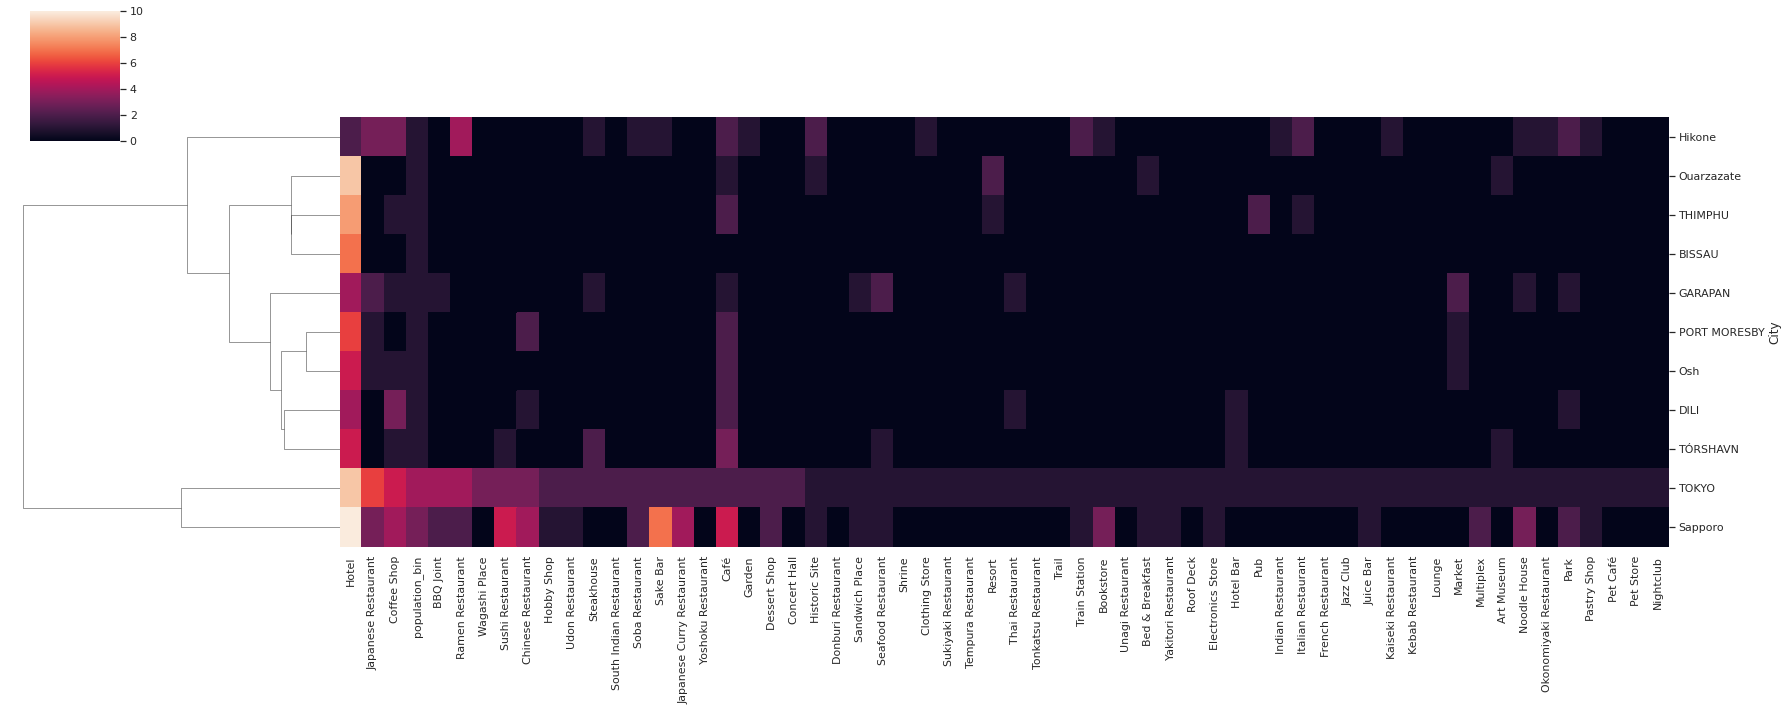

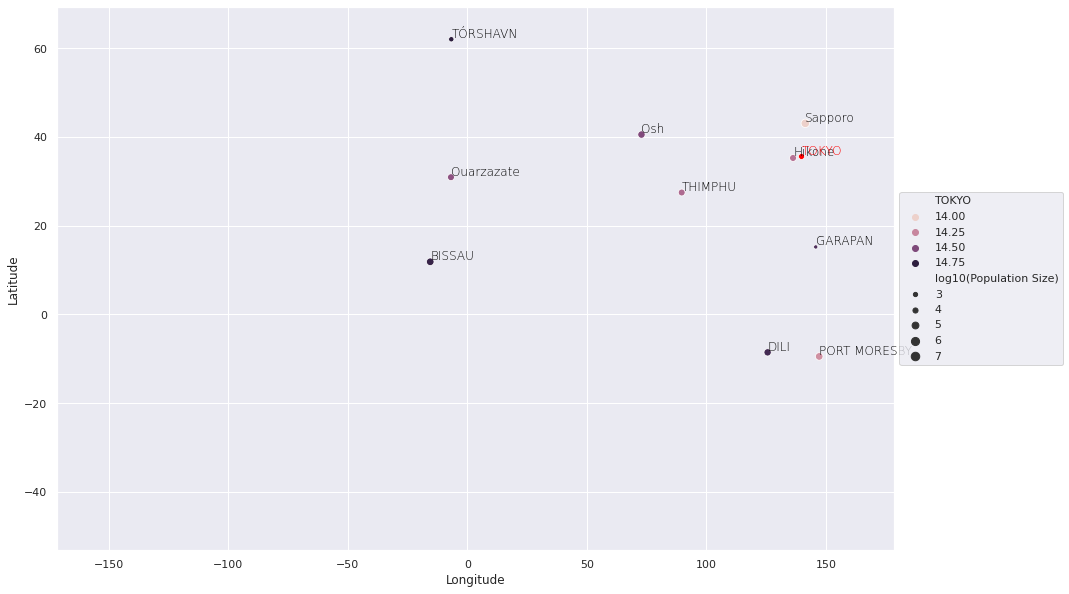

In [27]:
future_vacation_destination = find_next_vacation('TOKYO', population_venue_data, 10, 'euclidean')
future_vacation_destination.head()

### 5.1.5 WIEN, Austria

selected features
calculated distance matrix
found possible vacation destinations
plotting heatmap
plotting world map


,City,Population Size,Country,Latitude,Longitude,population_bin,Antique Shop,Art Museum,Asian Restaurant,Austrian Restaurant,Bakery,Bar,Beach Bar,Beer Store,Breakfast Spot,Brewery,Café,Canal,Cheese Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Electronics Store,Food & Drink Shop,Fountain,French Restaurant,Gastropub,Gourmet Shop,Greek Restaurant,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lebanese Restaurant,Lounge,Market,Movie Theater,Museum,Opera House,Palace,Park,Pedestrian Plaza,Peruvian Restaurant,Pizza Place,Plaza,Restaurant,Salad Place,Skating Rink,Steakhouse,Supermarket,Tapas Restaurant,Tea Room,Theater,Wine Bar,WIEN
5,WIEN,1888776.0,Austria,48.208354,16.372504,3,1,2,2,6,2,2,1,1,1,1,4,1,1,2,1,2,1,3,1,1,1,2,2,1,1,9,4,1,1,1,3,2,1,1,1,1,1,1,1,3,2,1,2,10,2,1,1,2,1,1,1,1,1,0.000000
4,Salzburg,153377.0,Austria,47.798135,13.046481,1,0,0,3,4,0,1,0,0,0,2,7,0,0,1,0,0,0,0,0,0,0,0,2,0,0,12,1,0,0,3,0,1,0,1,0,0,1,2,1,3,0,0,1,7,4,0,0,1,3,0,0,0,1,13.038405
7,Trieste,204286.0,Italy,45.650033,13.770656,1,0,1,0,0,0,1,1,0,0,1,5,0,0,0,0,1,2,0,0,0,1,0,2,2,0,6,7,0,0,5,2,0,0,2,0,0,0,0,0,1,1,0,2,5,1,0,0,0,2,0,0,1,0,15.297059
9,Salamanca,144207.0,Spain,40.965157,-5.664018,1,0,0,0,0,0,1,0,0,1,0,4,0,0,2,0,1,1,1,0,0,0,0,0,0,0,7,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,2,6,5,0,0,0,0,5,0,0,3,15.362291
6,Besançon,116676.0,France,47.238022,6.024362,1,0,0,0,0,0,3,0,0,0,0,2,0,0,0,0,0,1,2,1,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,4,2,0,0,0,1,0,0,0,1,15.394804


<Figure size 1080x720 with 0 Axes>

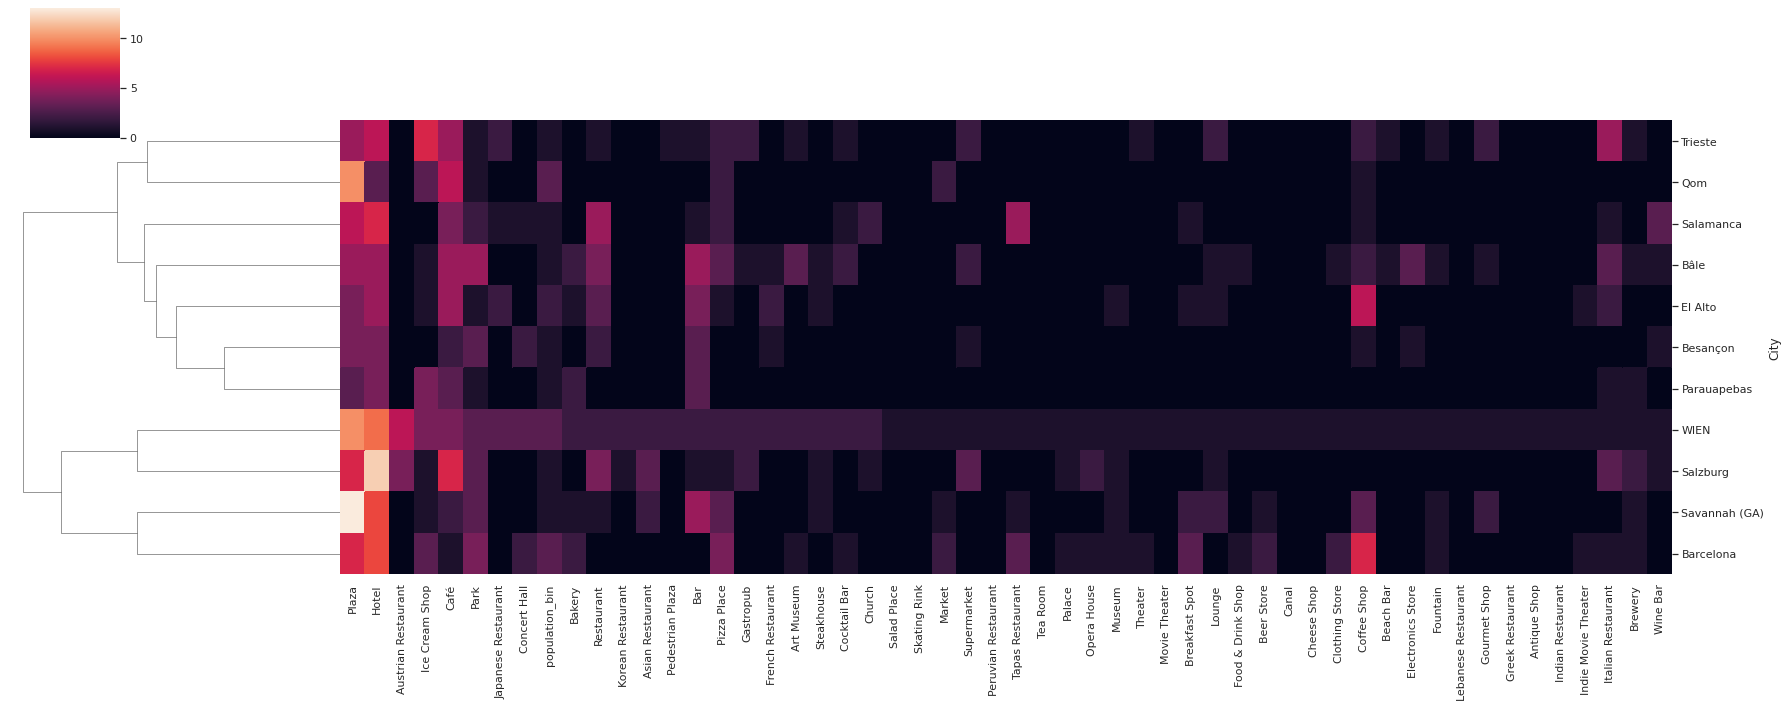

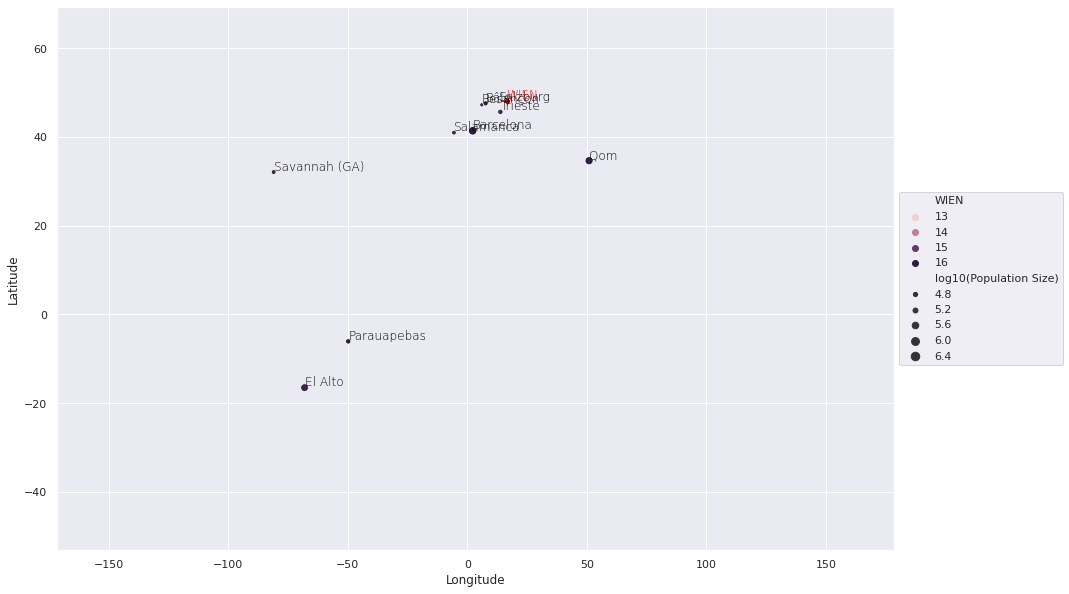

In [28]:
future_vacation_destination = find_next_vacation('WIEN', population_venue_data, 10, 'euclidean')
future_vacation_destination.head()

### 5.2 pretend to select a city  


Our first example input 'BERLIN' revealed, that s-Gravenhage (The Netherlands) is quite similar to Berlin (Germany). It has a similar amount of coffee shops, parks and other cultural as well as cousine related venues. Furthermore, s-Gravenhage is smaller than Berlin and far less known. Let's use the function `get_information_on_next_vacation` to find out more about s-Gravenhage.

### 5.3 use `foursquare` to get more information on an example city  

In [29]:
future_vacation_destination_info_Gravenhage = get_information_on_next_vacation('s-Gravenhage', future_vacation_destination_Berlin, 20)
future_vacation_destination_info_Gravenhage

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,s-Gravenhage,52.074946,4.26968,De Kaasspeciaalzaak Ed Boele,52.078564,4.269424,Deli / Bodega
1,s-Gravenhage,52.074946,4.26968,cafe madeleine,52.078751,4.276190,Tea Room
2,s-Gravenhage,52.074946,4.26968,Zondag lunchroom,52.079630,4.268465,Café
3,s-Gravenhage,52.074946,4.26968,Restaurant Rakang Thai,52.077110,4.278414,Thai Restaurant
4,s-Gravenhage,52.074946,4.26968,Emma,52.076730,4.282776,Bar
5,s-Gravenhage,52.074946,4.26968,Lokaal Duinoord,52.081865,4.283114,Bar
6,s-Gravenhage,52.074946,4.26968,Spijssalon,52.076284,4.281959,Ice Cream Shop
7,s-Gravenhage,52.074946,4.26968,Indonesisch restaurant Didong,52.084012,4.278235,Indonesian Restaurant
8,s-Gravenhage,52.074946,4.26968,Koemans Snacks & Broodjes,52.078317,4.269743,Snack Place
9,s-Gravenhage,52.074946,4.26968,Gemeentemuseum Den Haag,52.089290,4.280291,Museum


It looks like our next vacation will be filled with food and a little bit of culture.

In [39]:
# save output tables of Berlin and Gravenhage for report
future_vacation_destination_Berlin.iloc[:,[0,1,2,3,4,5,6, 23, 48,64]].to_csv('tables/Berlin.txt', sep = '&', index = False)
future_vacation_destination_info_Gravenhage.to_csv('tables/Gravenhage.txt', sep = '&', index = False)

## Possible discussion points and future directions. 
- select more cities and create an average of input cities
- better input data (missing couple countries)
- write a FLASK App
- include feature selection- select more cities and use K-means clustering with selected cities as input
  - show top venues for each cluster
  - build recommender engine for selecting multiple cities


- on the same principle it would be possible to investigate the next country 
- one big problem when using the foursquare API is the limit of 100 venues per request, so some cities might be under estimated
